## Programación Entera
### Estrategia Neutral con Opciones
En este ejemplo se plantea una estrategia nuetral con opciones, vendiendo una cesta de opciones que se cubra con una compra de la opción sobre el índice correspondiente.  El inconveniente para el IBEX es que no todos los valores tienen opciones cotizando y además los multiplicadores de las opciones no nos permiten replicar exactamente la exposición al índice.  Por tando el objetivo consiste en **determinar el número de contratos a vender de cada opción disponible, de modo que se reproduzca el nominal contratado en la opción sobre el índice**


In [3]:
import sys
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

### Datos
Datos de mercado del IBEX35 y de sus componentes

In [4]:
import pickle
with open('../data/stock_data.pkl', 'rb') as handle:
    stock_data = pickle.load(handle)
with open('../data/benchmark.pkl', 'rb') as handle:
    benchmark = pickle.load(handle)

In [5]:
close_dict = {tk: df.close for tk, df in stock_data.items()}
close_df = pd.DataFrame(close_dict)

In [6]:
close_year = close_df.loc['2019-09-02':'2019-12-31']
stock_close = close_year.dropna(axis=1)

In [7]:
bm_year = benchmark['ibex'].close

Tenemos la lista de acciones que tienen cotizando 
opciones en MEFF

In [8]:
liquid_tk = ['SAN', 'BBVA', 'ITX', 'TEF', 'REP',
             'IBE', 'CLNX', 'AMS', 'ELE', 'IAG',
             'FER', 'GRF', 'REE', 'ENG', 'NTGY',
             'ACS', 'CABK', 'ACX']

In [9]:
ibd = benchmark['ibex'].close

seleccionamos solo los precios de cierre de las acciones 
sobre las que vamos a trabajar. Haremos la estimación
utilizando los últimos 3 meses del 2019

In [10]:
liquid_close = stock_close[liquid_tk]
liquid_close.tail()

,SAN,BBVA,ITX,TEF,REP,IBE,CLNX,AMS,ELE,IAG,FER,GRF,REE,ENG,NTGY,ACS,CABK,ACX
2019-12-23,3.7650,4.815874,31.66,6.454,13.405322,8.742355,35.893408,72.220601,23.613766,7.284,26.304912,31.97,16.971419,22.265315,22.450488,32.271434,2.720152,9.980
2019-12-24,3.7550,4.788436,31.77,6.412,13.410059,8.710325,35.781590,73.153632,23.670124,7.340,26.450888,31.98,16.929097,22.418605,22.372024,32.809292,2.713428,9.942
2019-12-27,3.7565,4.767621,32.15,6.414,13.452691,8.781921,36.452495,73.094077,23.942518,7.372,26.411961,32.08,17.093685,22.399444,22.430872,32.633097,2.709586,9.974
2019-12-30,3.7425,4.735452,31.75,6.320,13.381638,8.746123,35.455456,72.379415,23.536880,7.300,26.022692,31.70,16.999634,22.226993,22.362216,32.633097,2.685573,10.050
2019-12-31,3.7300,4.714637,31.45,6.227,13.196900,8.648148,35.753636,72.260304,22.976708,7.220,26.246522,31.43,16.858559,21.786285,21.969896,33.059673,2.687494,10.045


Una opción sobre el índice tiene multiplicador 1, por lo que utilizaremos un factor sobre 
el precio del IBEX para representar el nominal total sobre el que queremos trabajar
Ver detalles en la descripción del [opciones sobre el IBEX35](https://www.meff.es/esp/Derivados-Financieros/Opciones-sobre-IBEX35)

In [11]:
bm_factor = 10

In [12]:
n_stocks = len(liquid_tk)
n_days = liquid_close.shape[0]
n_stocks, n_days

(18, 85)

Las variables de decisión 
- Numero de contratos de cada opción
- variables de error de cada día que se deben minimizar

In [13]:
var_contract = cp.Variable(n_stocks, integer=True)
var_epsilon = cp.Variable(n_days)

Restricciones
- el nominal de los contratos de opciones de la cesta menos de los contratos sobre el índice debe ser igual al error del día
- la cantidad de contratos no puede ser negativa

In [14]:
day_constraints = []
i = 0
for iday, iprices in liquid_close.iterrows():
    i_constraint = (var_contract @ (iprices.values*100)) - ibd.loc[iday]*bm_factor == var_epsilon[i]
    day_constraints = day_constraints + [i_constraint]
    i += 1 

In [15]:
constraints = [ var_contract >= 0]
constraints.extend(day_constraints)

Minimizamos la suma de los valores absolutos de los errores

In [16]:
objective = cp.Minimize(cp.sum(cp.abs(var_epsilon)))

In [17]:
prob = cp.Problem(objective, constraints)

In [18]:
prob.solve()

6174.157227430195

Solución

In [19]:
solucion = pd.Series(var_contract.value, index=liquid_close.columns)
solucion.round(2)

SAN     40.0
BBVA     8.0
ITX      4.0
TEF     19.0
REP      0.0
IBE     14.0
CLNX     1.0
AMS      1.0
ELE      2.0
IAG      3.0
FER      1.0
GRF      0.0
REE      1.0
ENG      0.0
NTGY     2.0
ACS      2.0
CABK    13.0
ACX      4.0
dtype: float64

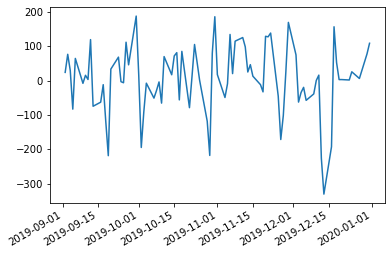

In [20]:
all_nominal = (solucion * liquid_close * 100)
diff_nominal = all_nominal.sum(axis=1) - ibd*bm_factor
diff_nominal.plot()

In [24]:
nominales = liquid_close.iloc[-1] * solucion * 100

In [25]:
nominales/nominales.sum()

SAN     0.156065
BBVA    0.039452
ITX     0.131588
TEF     0.123757
REP     0.000000
IBE     0.126645
CLNX    0.037399
AMS     0.075585
ELE     0.048068
IAG     0.022657
FER     0.027454
GRF     0.000000
REE     0.017634
ENG     0.000000
NTGY    0.045961
ACS     0.069162
CABK    0.036545
ACX     0.042029
dtype: float64